In [94]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import requests
import eia_api
import seaborn as sns
import geopandas as gpd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import contextily as cx
from sridentify import Sridentify
import statistics
states = ["AL", "AR", "AZ","CA", "CO", "CT", "DC", "DE", "FL", "GA", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
us_state_abbrev = {'the United States':'US','Alabama': 'AL','Alaska': 'AK','American Samoa': 'AS','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO', 'Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC', 'Florida': 'FL','Georgia': 'GA','Guam': 'GU','Hawaii': 'HI', 'Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA', 'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO', 'Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC', 'North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA','Puerto Rico': 'PR', 'Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT', 'Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'}
abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))
plt.style.use('ggplot')
api_key = 'c539dd02b98ef2d57482dfe39f7d6980'
my_url = 'http://api.eia.gov/series/?api_key=' + api_key + '&series_id='

In [95]:
def get_tags(sa):
    #Estimate DC City Gate using Maryland 
    #(idea from "Who Will Pay For Legacy Utility Costs" methodology)
    if(sa=='DC'):
        tags = ['NG.N3050'+'MD'+'3.A','NG.N3010'+sa+'3.A','NG.N3020'+sa+'3.A','SEDS.ESRCD.'+sa+'.A','SEDS.ESCCD.'+sa+'.A']
    else:
        tags = ['NG.N3050'+sa+'3.A','NG.N3010'+sa+'3.A','NG.N3020'+sa+'3.A','SEDS.ESRCD.'+sa+'.A','SEDS.ESCCD.'+sa+'.A']
    return tags
def get_cgp(year,sa):
    df = eia_api.get_series(2019,2019,sa,get_tags(sa))
    return df.iloc[0,0]
def get_resrev(year,sa):
    df = eia_api.get_series(2019,2019,sa,get_tags(sa))
    return df.iloc[1,0] - df.iloc[0,0]
def get_prices(year,sa):
    df = eia_api.get_series(2019,2019,sa,get_tags(sa))
    return [df.iloc[0,0], df.iloc[1,0], df.iloc[2,0], df.iloc[3,0], df.iloc[4,0]]

In [96]:
ident = Sridentify()
filename = '../Static/GIS_Data/cb_2018_us_state_20m/cb_2018_us_state_20m.'
ident.from_file(filename+'prj')
ident.get_epsg()
st = gpd.GeoDataFrame(gpd.read_file(filename+'shp'))
st.crs = 'epsg:4269'
st = st[(st['STUSPS']!='AK')&(st['STUSPS']!='HI')&(st['STUSPS']!='PR')]
st = st.to_crs('epsg:3857')
st = st.filter(['STATEFP','STUSPS','NAME','geometry'])

In [97]:
df = eia_api.get_series(2019,2019,sa,get_tags(sa))
df.head()

Year,2019
"Natural Gas Citygate Price in Wyoming, Annual (Dollars per Thousand Cubic Feet)",3.48
"Wyoming Price of Natural Gas Delivered to Residential Consumers, Annual (Dollars per Thousand Cubic Feet)",8.06
"Wyoming Price of Natural Gas Sold to Commercial Consumers, Annual (Dollars per Thousand Cubic Feet)",6.30
"Electricity price in the residential sector, Wyoming (Dollars per million Btu)",32.75
"Electricity price in the commercial sector, Wyoming (Dollars per million Btu)",28.26


In [98]:
year = 2019

In [100]:
prices = []
for i in st.index:
    prices.append(get_prices(year, st.at[i,'STUSPS']))
st['NGCityGatePrice'] = [i[0] for i in prices]
st['NGResPrice'] = [i[1] for i in prices]
st['NGComPrice'] = [i[2] for i in prices]
st['ElecResPrice'] = [i[3] for i in prices]
st['ElecComPrice'] = [i[4] for i in prices]
st['NGResRev'] = [i[1] - i[0] for i in prices]
st['NGComRev'] = [i[2] - i[0] for i in prices]
st['NG_CGR_Ratio'] = [(st.at[i,'NGResPrice']+st.at[i,'NGCityGatePrice'])/st.at[i,'NGCityGatePrice'] for i in st.index]

KeyError: 'ResPrice'

In [103]:
st.head(2)

,STATEFP,STUSPS,NAME,geometry,NGCityGatePrice,NGResPrice,NGComPrice,ElecResPrice,ElecComPrice,NGResRev,NGComRev,NG_CGR_Ratio
0,24,MD,Maryland,"MULTIPOLYGON (((-8465425.169 4583033.361, -846...",4.82,12.55,10.14,38.44,29.21,7.73,5.32,3.603734
1,19,IA,Iowa,"POLYGON ((-10755897.924 5278432.337, -10751006...",3.47,8.19,6.03,36.52,29.29,4.72,2.56,3.360231


### Calculate the cost of heating in each state:
    
KEY ASSUMPTIONS: Natural gas furnaces have an AFUE of 80%. Electric heat pumps have COP of 3.    

**Electric Heat Pump:** 
Original electricity prices are given in $/MMBTU.

Assumptions: Energy Content = 3412 BTU/kWh; Energy Price = (EIA Data $/MMBTU) * (1MMBTU/293.07kWh); Heat Conversion Efficiency = 300% (same as COP=3).

$/MMBTU Electric Heat Pump Heating = (EIA Data Price * (1/293.07)) * (1/3412) * (100/300) * (1000000) = EIA Price * 0.3333

**Natural Gas Furnace:**
Original prices are given in $/TCF. Need to be converted into therms.

Assumptions: Energy content = 100000BTU/Therms; Energy Price = (EIA Data $/TCF) * (10.002 Therms/TCF); Heat Conversion Efficiency = 80\%

$/MMBTU Gas Heating = (EIA Data Price * (1/10.002)) * (1/100000) * (100/80) * (1000000) = EIA Price * 1.1762


In [123]:
hp_cop = 3
hp_factor = (1/293.07) * (1/3412) * (1/hp_cop) * 1000000
gas_afue = .8
gas_factor = (1/10.002) * (1/100000) * (1/gas_afue) * 1000000

st['$/MMBTU Heat Pump'] = [st.at[i,'ElecResPrice']*hp_factor for i in st.index]
st['$/MMBTU Gas Furnace'] = [st.at[i,'NGResPrice']*gas_factor for i in st.index]

HPGasDiff --> how many $ per MMBTU of heating is saved by switching to a heat pump.

In [134]:
st['HPGasDiff'] = [st.at[i,'$/MMBTU Gas Furnace'] - st.at[i,'$/MMBTU Heat Pump'] for i in st.index]

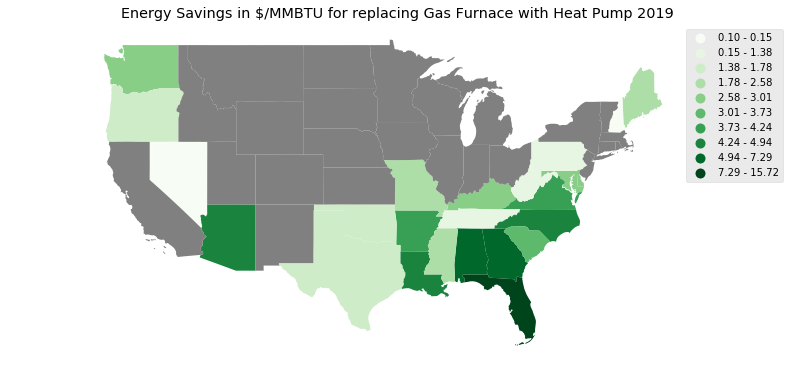

In [145]:
ax = st[st.HPGasDiff>0].plot(figsize=(14, 14), cmap='Greens', 
                              column='HPGasDiff', legend=True, scheme='NaturalBreaks',k=10)
st[st.HPGasDiff<0].plot(ax=ax,color='grey')
ax.set_title('Energy Savings in $/MMBTU for replacing Gas Furnace with Heat Pump ' + str(year))
ax.set_xlim(-15000000,-6000000)
ax.axis('off')
plt.show()
plt.close()

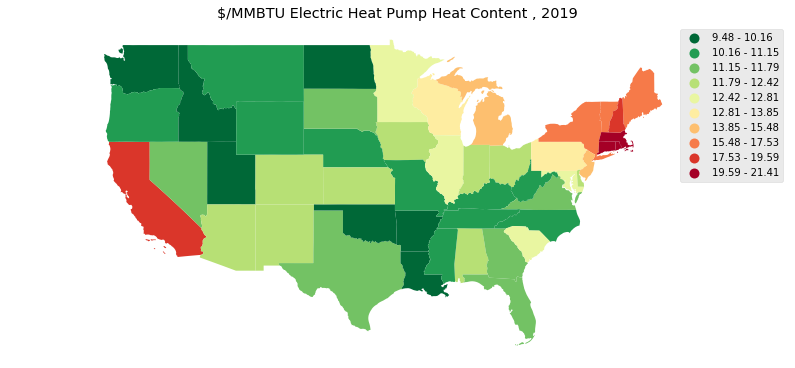

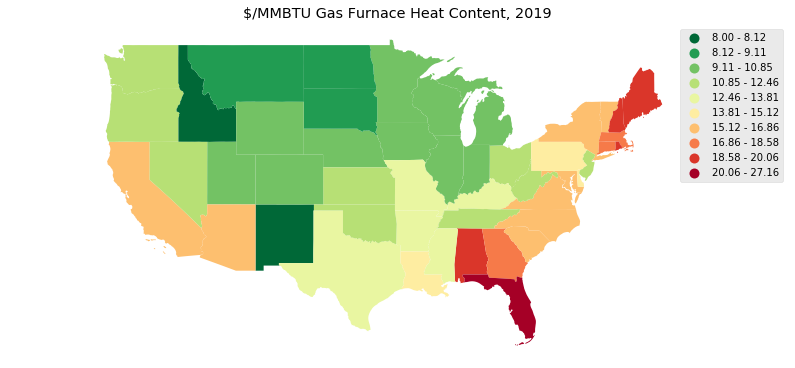

In [131]:
ax = st.plot(figsize=(14, 14), cmap='RdYlGn_r', 
                              column='$/MMBTU Heat Pump', legend=True, scheme='NaturalBreaks',k=10)
ax.set_title('$/MMBTU Electric Heat Pump Heat Content , ' + str(year))
ax.set_xlim(-15000000,-6000000)
ax.axis('off')
plt.show(), plt.close()

ax = st.plot(figsize=(14, 14), cmap='RdYlGn_r', 
                              column='$/MMBTU Gas Furnace', legend=True, scheme='NaturalBreaks',k=10)
ax.set_title('$/MMBTU Gas Furnace Heat Content, ' + str(year))
ax.set_xlim(-15000000,-6000000)
ax.axis('off')
plt.show()
plt.close()

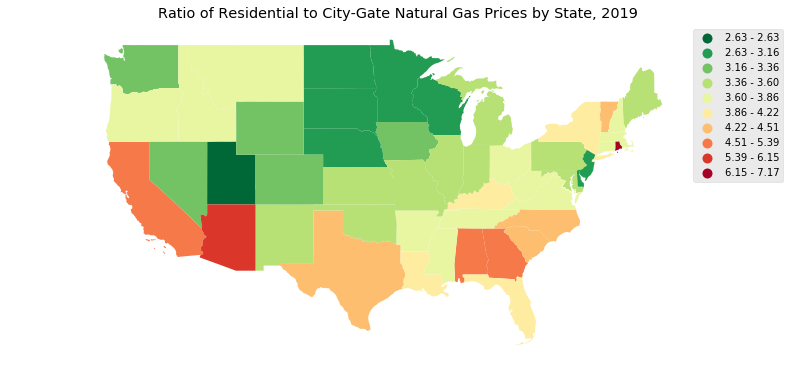

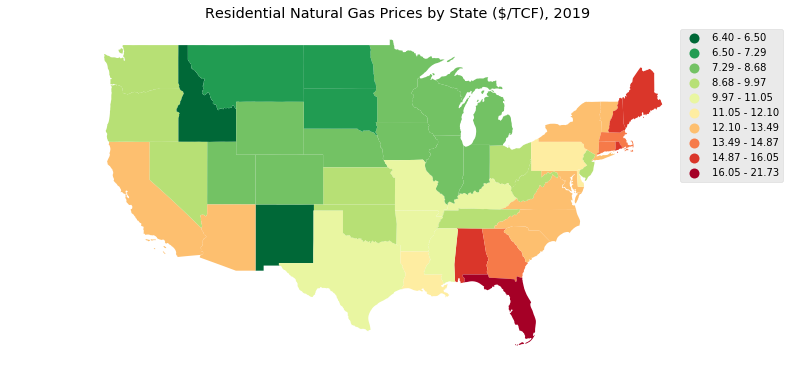

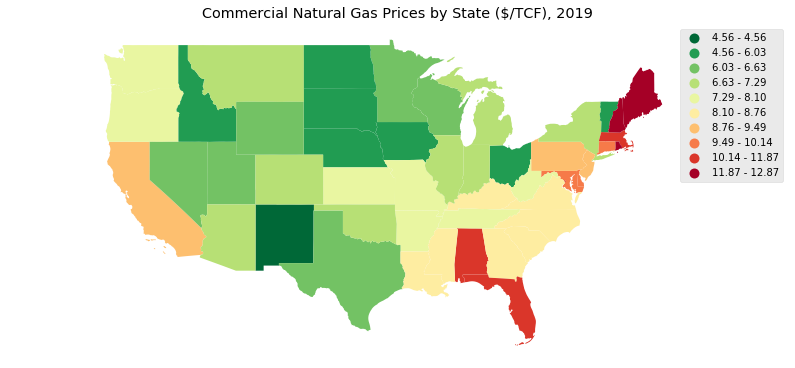

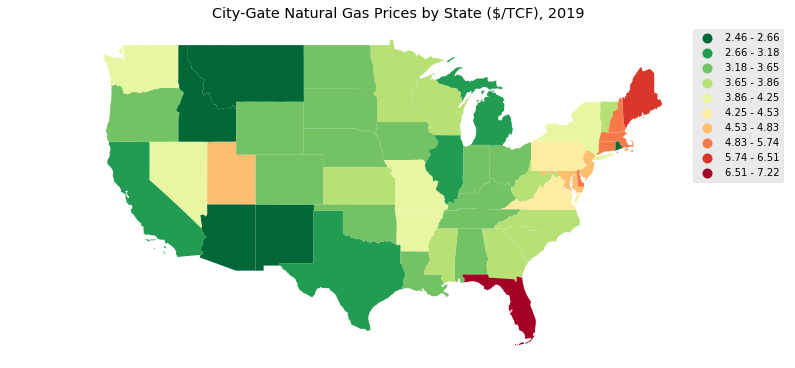

In [104]:
ax = st.plot(figsize=(14, 14), cmap='RdYlGn_r', 
                              column='NG_CGR_Ratio', legend=True, scheme='NaturalBreaks',k=10)
ax.set_title('Ratio of Residential to City-Gate Natural Gas Prices by State, ' + str(year))
ax.set_xlim(-15000000,-6000000)
ax.axis('off')
plt.show(), plt.close()

ax = st.plot(figsize=(14, 14), cmap='RdYlGn_r', 
                              column='NGResPrice', legend=True, scheme='NaturalBreaks',k=10)
ax.set_title('Residential Natural Gas Prices by State ($/TCF), ' + str(year))
ax.set_xlim(-15000000,-6000000)
ax.axis('off')
plt.show(), plt.close()

ax = st.plot(figsize=(14, 14), cmap='RdYlGn_r', 
                              column='NGComPrice', legend=True, scheme='NaturalBreaks',k=10)
ax.set_title('Commercial Natural Gas Prices by State ($/TCF), ' + str(year))
ax.set_xlim(-15000000,-6000000)
ax.axis('off')
plt.show(), plt.close()

ax = st.plot(figsize=(14, 14), cmap='RdYlGn_r', 
                              column='NGCityGatePrice', legend=True, scheme='NaturalBreaks',k=10)
ax.set_title('City-Gate Natural Gas Prices by State ($/TCF), ' + str(year))
ax.set_xlim(-15000000,-6000000)
ax.axis('off')
plt.show()